In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib
import random
import torch
import os

from matplotlib.backends.backend_agg import FigureCanvasAgg
from collections import defaultdict
from torchvision import transforms
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn import metrics
from scipy.spatial import ConvexHull
from pathlib import Path
from tqdm import tqdm

import lightglue
from lightglue import LightGlue, SuperPoint, DISK, viz2d
from lightglue.utils import rbd

from utils import *

In [21]:
df_test, test_dataset, match_results, q_pids, topk_idx, topk_names, match_mat, distmat, images = load_miewid_data('/home/cabidi/XAI/wbia-plugin-miew-id/wbia_miew_id/runs/miewid-training/beluga-example-exp-1/visualizations')

[PosixPath('/home/cabidi/XAI/wbia-plugin-miew-id/wbia_miew_id/runs/miewid-training/beluga-example-exp-1/visualizations/vis_147_up_558_top20.jpg'), PosixPath('/home/cabidi/XAI/wbia-plugin-miew-id/wbia_miew_id/runs/miewid-training/beluga-example-exp-1/visualizations/vis_110_up_419_top20.jpg'), PosixPath('/home/cabidi/XAI/wbia-plugin-miew-id/wbia_miew_id/runs/miewid-training/beluga-example-exp-1/visualizations/vis_90_up_359_top20.jpg'), PosixPath('/home/cabidi/XAI/wbia-plugin-miew-id/wbia_miew_id/runs/miewid-training/beluga-example-exp-1/visualizations/vis_19_up_114_top20.jpg'), PosixPath('/home/cabidi/XAI/wbia-plugin-miew-id/wbia_miew_id/runs/miewid-training/beluga-example-exp-1/visualizations/vis_124_up_471_top20.jpg'), PosixPath('/home/cabidi/XAI/wbia-plugin-miew-id/wbia_miew_id/runs/miewid-training/beluga-example-exp-1/visualizations/vis_128_up_497_top20.jpg'), PosixPath('/home/cabidi/XAI/wbia-plugin-miew-id/wbia_miew_id/runs/miewid-training/beluga-example-exp-1/visualizations/vis_36_

  0%|          | 0/849 [00:00<?, ?it/s]

100%|██████████| 849/849 [00:04<00:00, 170.16it/s]


Loaded images: torch.Size([849, 3, 440, 440])


In [37]:
def compute_convex_polygons(X: ..., dbscan_kwargs: dict = {"eps":0.3, "min_samples":3}) -> [ConvexHull]:
    """A polygon generator that uses the DBSCAN and ConvexHull algorithms from sklearn.

    Args:
        X (np.array, torch.Tensor): (num_samples,...)-shaped array of un-normalized data points
        dbscan_kwargs (dict, optional): kwargs to provide to DBSCAN. Defaults to {"eps":0.5, "min_samples":3}.

    Returns:
        output: a set of k  drawn in the same (un-normalized) coordinate system as X
    """
    if not isinstance(X, type(np.array)):
        X = np.array(X)
    
    # Normalize input data
    scaler = StandardScaler()
    scaler.fit(X)
    X_new = scaler.transform(X)
    # print(f"X mean: {scaler.mean_}\nX variance: {scaler.var_}")

    # Run DBSCAN
    # print(f"Running DBSCAN with args {dbscan_kwargs}")
    db = DBSCAN(**dbscan_kwargs).fit(X_new)

    # Number of clusters in labels, ignoring noise if present.
    # n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    # n_noise_ = list(db.labels_).count(-1)
    # print("Estimated number of clusters: %d" % n_clusters_)
    # print("Estimated number of noise points: %d" % n_noise_)

    # Extract the convex hull for each core sample set
    hulls = []
    for label in set(db.labels_):
        # Condition on samples matching label
        label_mask = np.zeros_like(db.labels_, dtype=bool)
        label_mask[db.labels_ == label] = True
        
        # Condition on samples in current core set
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        
        # Extract core sample set
        core_points = X[core_samples_mask & label_mask]

        # Compute convex hull if there are more samples than lower bound
        if len(core_points) > 3:
            hull = ConvexHull(core_points)
            hulls.append(hull)

    return hulls
    
    # Un-normalize data
    # hulls = np.array(hulls)
    # if len(hulls) > 0:
    #     hulls_denormalized = scaler.inverse_transform(hulls)
    #     return hulls_denormalized
    # return hulls

def _lightglue(extractor, matcher, image0: torch.Tensor, image1: torch.Tensor) -> dict:
    feats0 = extractor.extract(image0.to(device))
    feats1 = extractor.extract(image1.to(device))
    matches01 = matcher({"image0": feats0, "image1": feats1})
    return feats0, feats1, matches01

In [75]:
### Boilerplate setup
# Files
saveroot = "/srv/transparency/wildbook_prototype/data/matches/figures/lightglue/"
os.makedirs(saveroot, exist_ok=True)

# Tabular data
df = pd.DataFrame()

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

# LightGlue+SuperPoint
extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)
matcher = LightGlue(features="superpoint").eval().to(device)

### Construct data for query-match pairs
idx_to_match_idxs = {
    idx:{"topk_indices":topk_idx[idx].tolist(), "match_indicators":match_mat[idx].tolist()}
    for idx in range(len(images))
}
for i, (query_idx, vals) in enumerate(tqdm(idx_to_match_idxs.items())):
    # Extract query image
    image0 = images[query_idx]

    # Extract top-k indices of matches and whether they were true matches or not
    topk_indices = vals["topk_indices"]
    match_indicators = vals["match_indicators"]

    # Iterate through top-k matches
    rendered_images = []
    rendered_polygon_images = []
    for rank, (match_idx, is_match) in enumerate(zip(topk_indices, match_indicators)):
        # Extract match image
        image1 = images[match_idx]

        # Run LightGlue
        feats0, feats1, matches01 = _lightglue(extractor, matcher, image0, image1)

        # Visualize with lines and polygons
        savepath = Path(saveroot, f"lightglue_{query_idx}_{match_idx}.png")
        
        # Pre-processing: remove batch dimension
        feats0, feats1, matches01 = [
            rbd(x) for x in [feats0, feats1, matches01]
        ]
        kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
        m_kpts0, m_kpts1 = kpts0[matches[..., 0]].cpu().numpy(), kpts1[matches[..., 1]].cpu().numpy()

        # Generate hulls (requires >= match keypoints for convex polygon to be generated)
        if len(m_kpts0) >= 3:
            hulls_mkpts0 = compute_convex_polygons(m_kpts0, dbscan_kwargs={"eps":0.3, "min_samples":3})
        else:
            hulls_mkpts0 = []
        if len(m_kpts1) >= 3:
            hulls_mkpts1 = compute_convex_polygons(m_kpts1, dbscan_kwargs={"eps":0.3, "min_samples":3})
        else:
            hulls_mkpts0 = []

        # Post-processing on hulls to get them to fit in pandas dataframe
        # hulls_kpts0
        # hulls_kpts1

        # Extract score of query-match pair
        score = distmat[query_idx, match_idx]

        # Store computed results
        data = {
            "query_idx":    query_idx,
            "match_idx":    match_idx,
            "score":        score,
            "rank":         rank,
            "is_match":     is_match,
            "query_kpts":   [m_kpts0],
            "match_kpts":   [m_kpts1],
            "query_polygons":   [hulls_mkpts0], 
            "match_polygons":   [hulls_mkpts1],
            "query_num_polygons":   len(hulls_mkpts0),
            "match_num_polygons":   len(hulls_mkpts1),
            #"polygons_iou":
        }
        df = pd.concat((df, pd.DataFrame(data)), axis=0)
    
    if i > 50:
        break

  6%|▌         | 51/849 [00:58<15:10,  1.14s/it]


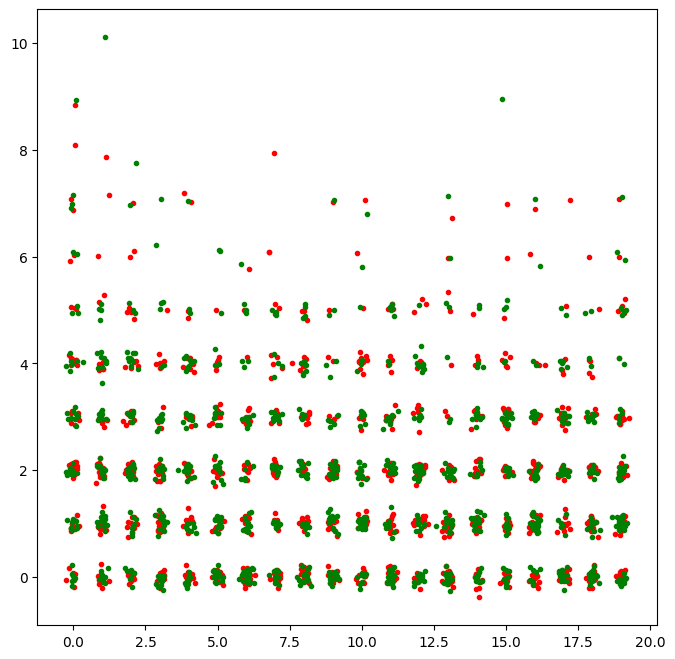

In [88]:
fig = plt.figure(figsize=(8,8))
ranks, query_num_polygons, match_num_polygons = list(df['rank']), list(df['query_num_polygons']), list(df['match_num_polygons'])
plt.scatter(ranks + np.random.normal(0.0, 0.1, size=len(ranks)), query_num_polygons + np.random.normal(0.0, 0.1, size=len(query_num_polygons)), c='red', marker='.')
plt.scatter(ranks + np.random.normal(0.0, 0.1, size=len(ranks)), match_num_polygons + np.random.normal(0.0, 0.1, size=len(match_num_polygons)), c='green', marker='.')
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn import metrics

# Get keypoints
f0, f1, m01 = [
        rbd(x) for x in [feats0, feats1, matches01]
    ]  # remove batch dimension

kpts0, kpts1, matches = f0["keypoints"].cpu(), f1["keypoints"].cpu(), m01["matches"].cpu()
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

# Normal scaling
X = StandardScaler().fit_transform(m_kpts0)

# Run DBSCAN
db = DBSCAN(eps=0.5, min_samples=3).fit(X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Extract core set
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

# Plot core vs non-core samples
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=5,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=3,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

### GradCam

In [ ]:
# INSERT GRADCAM INSTALLATION HERE #
#pip install ...

In [ ]:
# INSERT GRADCAM BOILERPLATE CODE HERE #
# imports

# helpers

# main functions
def _gradcam(*args):
    pass

def _vis_gradcam(*args):
    pass

In [ ]:
# BENCHMARK GRADCAM HERE #
#%timeit -n 100 _gradcam(random.choice(images), random.choice(images))

In [ ]:
# Iterate through instance-match pairs
idx_to_match_idxs = {idx:topk_idx[idx].tolist() for idx in range(len(images))}
for idx, match_idxs in tqdm(idx_to_match_idxs.items()):
    image0 = images[idx]
    for match in match_idxs:
        image1 = images[match]
        # INSERT GRADCAM VISUALIZATION CODE HERE #
        break
    break